In [1]:
!pip install -r Full_test_requirements.txt

Importing Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import faiss
import os
import wikipedia
import fitz
import nltk
import shutil
import re

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from langchain_community.llms import HuggingFaceEndpoint
from sklearn.metrics.pairwise import cosine_similarity
from langchain_huggingface import HuggingFaceEndpoint
from google.colab import userdata, files
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [4]:
import os
import cv2
import easyocr

Loading pdf Data

In [5]:
folder_name = 'pdfs'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(folder_name, filename))

Saving accountinginsights.orgwhat-does-churn-in-business-mean-for-your-revenue-and-profitability (1).pdf to accountinginsights.orgwhat-does-churn-in-business-mean-for-your-revenue-and-profitability (1).pdf


Loading Image data and retriving Text using OCR


Processing image: churn_rate_2.jpg
Detected text blocks:
 - Advantages and Disadvantages of the Churn Rate (score: 0.97)
 - Benefits of Using the Churn Rate (score: 0.68)
 - The advantage of calculating (score: 0.98)
 - company's churn rate is that it provides clarity (score: 0.76)
 - on how well the business is retaining customers, which is a reflection on the (score: 0.73)
 - quality of the service the business is providing; as well as its usefulness (score: 0.68)
 - If a company sees that its churn rate is increasing from period to period, this (score: 0.65)
 - can show that a (score: 0.97)
 - fundamental component of how it is running its business is (score: 0.80)
 - flawed: This can indicate a few potential problems: (score: 0.66)
 - Faulty product(s) (score: 0.99)
 - Poor customer service (score: 0.81)
 - Cost is higher than utility to customers (score: 0.65)
 - The churn rate Will indicate to (score: 0.86)
 - company that it needs to understand why its (score: 0.89)
 - clients 

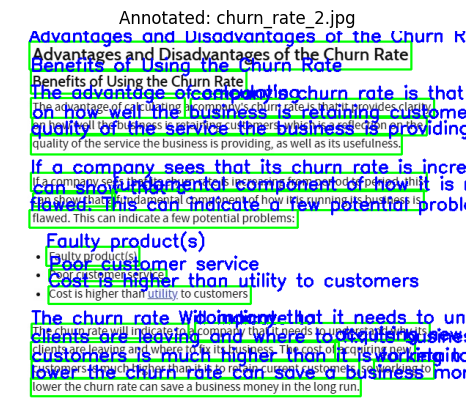


Processing image: churn_rate_3.jpg
Detected text blocks:
 - Limitations of Using the Churn Rate (score: 0.85)
 - One of the limitations of the churn rate is that it doesnot take into (score: 0.69)
 - consideration the types of customers that are leaving: Customer (score: 0.82)
 - primarily seen in the most recently acquired customers. (score: 0.74)
 - Perhaps your company had a recent promotion that attracted new customers (score: 0.77)
 - Once this promotion was over or even if the benefit of the promotion never (score: 0.69)
 - ended, customers that were trying out the product may determine it's not for (score: 0.73)
 - them, canceling their subscription: (score: 0.86)
 - The impact of losing new customers versus long-term customers is critical: (score: 0.84)
 - New customers are transient whereas old customers are entrenched and have (score: 0.88)
 - enjoyed (score: 1.00)
 - product; if (score: 0.78)
 - leave, that is usually due to (score: 0.75)
 - significant reason: (score: 0.74

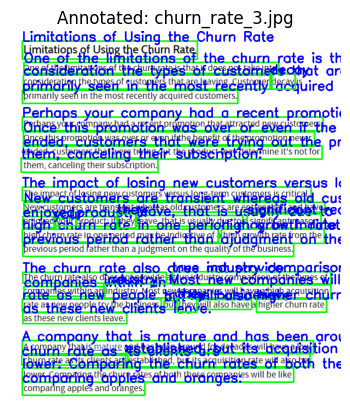


Processing image: churn_rate_1.jpg
Detected text blocks:
 - Understanding the Churn Rate (score: 0.77)
 - Churn rate reflects the rate at which a company loses customers or subscribers: (score: 0.75)
 - Ahigh churn rate could adversely affect profits and impede growth: What is (score: 0.80)
 - considered a good or bad churn rate can vary from industry to industry: (score: 0.85)
 - The churn rate not only includes when customers switch providers but also (score: 0.80)
 - includes when customers terminate service without switching: This (score: 0.70)
 - measurement is most valuable in subscriber-based businesses in which (score: 0.83)
 - subscription fees comprise most of the revenues (score: 0.71)


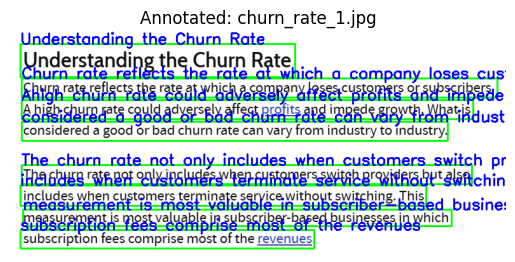


All OCR Chunks (ready for RAG):

[churn_rate_2.jpg] Advantages and Disadvantages of the Churn Rate Benefits of Using the Churn Rate The advantage of calculating company's churn rate is that it provides clarity on how well the business is retaining customers, which is a reflection on the quality of the service the business is providing; as well as its usefulness If a company sees that its churn rate is increasing from period to period, this can show that a fundamental component of how it is running its business is flawed: This can indicate a few potential problems: Faulty product(s) Poor customer service Cost is higher than utility to

[churn_rate_2.jpg] customers The churn rate Will indicate to company that it needs to understand why its clients are leaving and where to fix its business The cost of acquiring new customers is much higher than it is to retain current customers, working to lower the churn rate can save a business money in the long run:

[churn_rate_3.jpg] Limitations of 

In [6]:


image_folder = '/content/image_folder'  # Update this path to your folder containing images
threshold = 0.25
max_words_per_chunk = 100  # Adjust as needed

reader = easyocr.Reader(['en'], gpu=False)

# === Function to Chunk Text ===
def chunk_text(text, max_words=100):
    words = text.split()
    return [' '.join(words[i:i+max_words]) for i in range(0, len(words), max_words)]

all_text_chunks_img = []

for image_file in os.listdir(image_folder):
    if not image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        continue

    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path)

    text_detect = reader.readtext(img)
    detected_text = []

    print(f"\nProcessing image: {image_file}")
    print("Detected text blocks:")

    for t in text_detect:
        bbox, text, score = t
        if score > threshold:
            detected_text.append(text)
            print(f" - {text} (score: {score:.2f})")
            # Optional visualization
            bbox = [tuple(map(int, point)) for point in bbox]
            cv2.rectangle(img, bbox[0], bbox[2], (0, 255, 0), 2)
            cv2.putText(img, text, bbox[0], cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    full_text = ' '.join(detected_text)
    chunks_img = chunk_text(full_text, max_words=max_words_per_chunk)

    for chunk in chunks_img:
        all_text_chunks_img.append({
            'image_file': image_file,
            'chunk_text': chunk
        })

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Annotated: {image_file}")
    plt.axis('off')
    plt.show()

# === Final Output: List of Chunks ===
print("\nAll OCR Chunks (ready for RAG):\n")
for item in all_text_chunks_img:
    print(f"[{item['image_file']}] {item['chunk_text']}\n")


Loading CSV data

In [7]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/customer_churn.csv'
df = pd.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Data Cleaning

In [8]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [9]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [10]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df['TotalCharges'].mean(), inplace=True)

In [11]:
df=df[['customerID','gender','SeniorCitizen','Partner','tenure','InternetService','OnlineSecurity','MonthlyCharges', 'TotalCharges','Contract', 'Churn'] ]
df.head(2)

,customerID,gender,SeniorCitizen,Partner,tenure,InternetService,OnlineSecurity,MonthlyCharges,TotalCharges,Contract,Churn
0,7590-VHVEG,Female,0,Yes,1,DSL,No,29.85,29.85,Month-to-month,No
1,5575-GNVDE,Male,0,No,34,DSL,Yes,56.95,1889.50,One year,No


In [12]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
tenure,0
InternetService,0
OnlineSecurity,0
MonthlyCharges,0
TotalCharges,0
Contract,0


In [13]:
df = df[(df['tenure'] > 0)]
df.shape

(7032, 11)

In [14]:
df.groupby(['Churn', 'gender','Contract']).size()

Churn  gender  Contract      
No     Female  Month-to-month    1083
               One year           643
               Two year           818
       Male    Month-to-month    1137
               One year           663
               Two year           819
Yes    Female  Month-to-month     842
               One year            75
               Two year            22
       Male    Month-to-month     813
               One year            91
               Two year            26
dtype: int64

In [15]:
df5 = df[['gender','Contract','Churn']]
df_churn_count = df5.groupby(['Churn', 'gender','Contract']).size().reset_index(name='Count')
df_churn_count

,Churn,gender,Contract,Count
0,No,Female,Month-to-month,1083
1,No,Female,One year,643
2,No,Female,Two year,818
3,No,Male,Month-to-month,1137
4,No,Male,One year,663
5,No,Male,Two year,819
6,Yes,Female,Month-to-month,842
7,Yes,Female,One year,75
8,Yes,Female,Two year,22
9,Yes,Male,Month-to-month,813


<ipython-input-16-799aa5d9abd7>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sb.barplot(data=df_churn_count, x='Contract', y='Count', hue='Churn', ci=None,


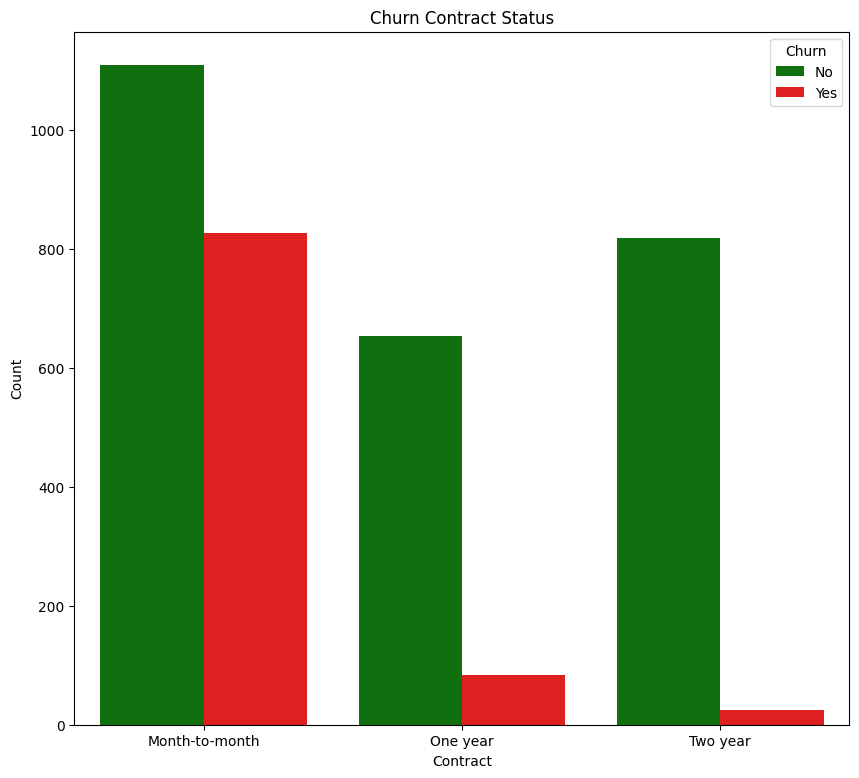

In [16]:
plt.figure(figsize=(10,9))
sb.barplot(data=df_churn_count, x='Contract', y='Count', hue='Churn', ci=None,
            palette={'Yes': 'red', 'No': 'green'}, dodge=True)

plt.xlabel("Contract")
plt.ylabel("Count")
plt.title("Churn Contract Status")
plt.legend(title="Churn")

plt.show()

In [17]:
df.TotalCharges.describe()

,TotalCharges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


In [18]:
Q1 = df['TotalCharges'].quantile(0.25)
Q3 = df['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1  #Interquartile Range

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Remove_outliers
df_cleaned = df[(df['TotalCharges'] >= lower_bound) & (df['TotalCharges'] <= upper_bound)]

print(f"Original size: {df.shape[0]}, After outlier removal: {df_cleaned.shape[0]}")

Original size: 7032, After outlier removal: 7032


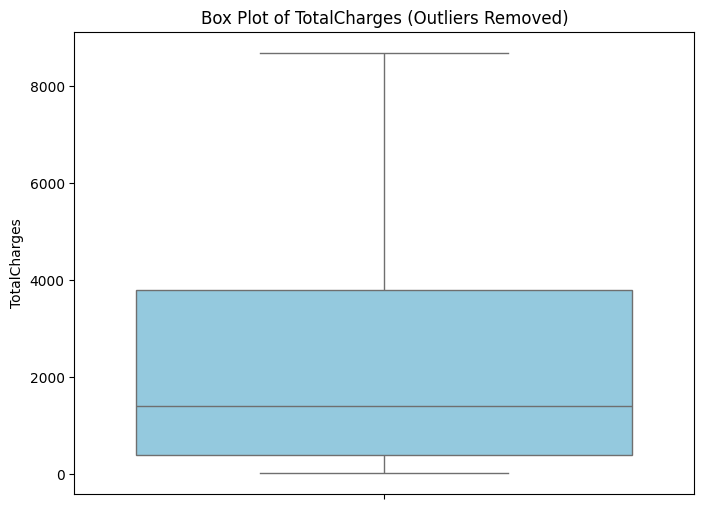

In [19]:
plt.figure(figsize=(8, 6))
sb.boxplot(data=df_cleaned, y='TotalCharges', color='skyblue')
plt.title("Box Plot of TotalCharges (Outliers Removed)")
plt.ylabel("TotalCharges")
plt.show()

In [20]:
df_MonthlyCharges=df[['Contract', 'InternetService' , 'MonthlyCharges']]
mean_monthly_charges = df_MonthlyCharges.groupby('Contract')['MonthlyCharges'].mean()
print(mean_monthly_charges)

Contract
Month-to-month    66.398490
One year          65.079416
Two year          60.872374
Name: MonthlyCharges, dtype: float64


In [21]:
ISP_mean_monthly_charges = df_MonthlyCharges.groupby('InternetService')['MonthlyCharges'].mean()
print(ISP_mean_monthly_charges)

InternetService
DSL            58.088017
Fiber optic    91.500129
No             21.076283
Name: MonthlyCharges, dtype: float64


In [22]:
columns_df = ", ".join(df.columns)
columns_df

'customerID, gender, SeniorCitizen, Partner, tenure, InternetService, OnlineSecurity, MonthlyCharges, TotalCharges, Contract, Churn'

In [23]:
df["SeniorCitizen"]= df["SeniorCitizen"].map({0: "No", 1: "Yes"})
df.head()

,customerID,gender,SeniorCitizen,Partner,tenure,InternetService,OnlineSecurity,MonthlyCharges,TotalCharges,Contract,Churn
0,7590-VHVEG,Female,No,Yes,1,DSL,No,29.85,29.85,Month-to-month,No
1,5575-GNVDE,Male,No,No,34,DSL,Yes,56.95,1889.50,One year,No
2,3668-QPYBK,Male,No,No,2,DSL,Yes,53.85,108.15,Month-to-month,Yes
3,7795-CFOCW,Male,No,No,45,DSL,Yes,42.30,1840.75,One year,No
4,9237-HQITU,Female,No,No,2,Fiber optic,No,70.70,151.65,Month-to-month,Yes


In [24]:
df.shape

(7032, 11)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerID       7032 non-null   object 
 1   gender           7032 non-null   object 
 2   SeniorCitizen    7032 non-null   object 
 3   Partner          7032 non-null   object 
 4   tenure           7032 non-null   int64  
 5   InternetService  7032 non-null   object 
 6   OnlineSecurity   7032 non-null   object 
 7   MonthlyCharges   7032 non-null   float64
 8   TotalCharges     7032 non-null   float64
 9   Contract         7032 non-null   object 
 10  Churn            7032 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 659.2+ KB


In [26]:
df['tenure'] = df['tenure'].astype('int32')
df['MonthlyCharges'] = df['MonthlyCharges'].astype('float32')
df['TotalCharges'] = df['TotalCharges'].astype('float32')

Creating Text csv chunks

In [27]:
df

,customerID,gender,SeniorCitizen,Partner,tenure,InternetService,OnlineSecurity,MonthlyCharges,TotalCharges,Contract,Churn
0,7590-VHVEG,Female,No,Yes,1,DSL,No,29.850000,29.850000,Month-to-month,No
1,5575-GNVDE,Male,No,No,34,DSL,Yes,56.950001,1889.500000,One year,No
2,3668-QPYBK,Male,No,No,2,DSL,Yes,53.849998,108.150002,Month-to-month,Yes
3,7795-CFOCW,Male,No,No,45,DSL,Yes,42.299999,1840.750000,One year,No
4,9237-HQITU,Female,No,No,2,Fiber optic,No,70.699997,151.649994,Month-to-month,Yes
...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,No,Yes,24,DSL,Yes,84.800003,1990.500000,One year,No
7039,2234-XADUH,Female,No,Yes,72,Fiber optic,No,103.199997,7362.899902,One year,No
7040,4801-JZAZL,Female,No,Yes,11,DSL,Yes,29.600000,346.450012,Month-to-month,No
7041,8361-LTMKD,Male,Yes,Yes,4,Fiber optic,No,74.400002,306.600006,Month-to-month,Yes


IMPORTING SQL

In [28]:
import sqlalchemy
import sqlite3
from sqlalchemy import create_engine

engine = sqlalchemy.create_engine('sqlite:///telcom_churn_data.db')
df.to_sql('CHURN_DATA', con=engine, index=False, if_exists='replace')

7032

In [29]:
monthlycharge_greaterthan_seventy = """
SELECT *
FROM CHURN_DATA
WHERE "MonthlyCharges" > 2
"""


df = pd.read_sql(monthlycharge_greaterthan_seventy, con=engine)
df

,customerID,gender,SeniorCitizen,Partner,tenure,InternetService,OnlineSecurity,MonthlyCharges,TotalCharges,Contract,Churn
0,7590-VHVEG,Female,No,Yes,1,DSL,No,29.850000,29.850000,Month-to-month,No
1,5575-GNVDE,Male,No,No,34,DSL,Yes,56.950001,1889.500000,One year,No
2,3668-QPYBK,Male,No,No,2,DSL,Yes,53.849998,108.150002,Month-to-month,Yes
3,7795-CFOCW,Male,No,No,45,DSL,Yes,42.299999,1840.750000,One year,No
4,9237-HQITU,Female,No,No,2,Fiber optic,No,70.699997,151.649994,Month-to-month,Yes
...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,No,Yes,24,DSL,Yes,84.800003,1990.500000,One year,No
7028,2234-XADUH,Female,No,Yes,72,Fiber optic,No,103.199997,7362.899902,One year,No
7029,4801-JZAZL,Female,No,Yes,11,DSL,Yes,29.600000,346.450012,Month-to-month,No
7030,8361-LTMKD,Male,Yes,Yes,4,Fiber optic,No,74.400002,306.600006,Month-to-month,Yes


In [30]:
grouped = df.groupby("customerID")
chunks_csv = []
metadata = []

for name, group in grouped:

    text_chunk = f"customerID: {name}\n"
    for _, row in group.iterrows():
        entry = f"  - customerID: {row['customerID']}, gender: {row['gender']}, SeniorCitizen: {row['SeniorCitizen']}, Partner: {row['Partner']}, tenure: {row['tenure']} , InternetService: {row['InternetService']} , OnlineSecurity: {row['OnlineSecurity']} , MonthlyCharges: {row['MonthlyCharges']}, TotalCharges: {row['TotalCharges']}, Contract: {row['Contract']}, Churn: {row['Churn']}"
        text_chunk += entry + "\n"

    chunks_csv.append(text_chunk)
    metadata.append({"group": name})

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Loading* Wikepedia and creating chunks

In [32]:
wiki_topics = ["Churn rate"]
wiki_chunks = []
wiki_metadata = []

for topic in wiki_topics:
    try:
        content = wikipedia.page(topic).content
        chunks = [content[i:i+512] for i in range(0, len(content), 512)]
        wiki_chunks.extend(chunks)
        wiki_metadata.extend([{"source": "wikipedia", "topic": topic}] * len(chunks))
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Disambiguation required for: {topic}, options: {e.options}")
    except wikipedia.exceptions.PageError:
        print(f"Page not found: {topic}")

Creating PDF chunks

In [33]:

pdf_folder = "pdfs"
pdf_chunks = []
pdf_metadata = []

for file_name in os.listdir(pdf_folder):
    if file_name.endswith(".pdf"):
        file_path = os.path.join(pdf_folder, file_name)
        doc = fitz.open(file_path)
        for page in doc:
            text = page.get_text()
            chunks = [text[i:i+512] for i in range(0, len(text), 512)]
            pdf_chunks.extend(chunks)
            pdf_metadata.extend([{"source": "pdf", "file": file_name}] * len(chunks))



Standardizing all the chunks together

In [34]:
standardized_chunks = []


for i, text in enumerate(pdf_chunks):
    standardized_chunks.append({
        'chunk_text': text,
        'source': 'pdf',
        'section': f'pdf_chunk_{i}'
    })

for i, text in enumerate(chunks_csv):
    standardized_chunks.append({
        'chunk_text': text,
        'source': 'csv',
        'section': f'csv_row_{i}'
    })

for i, text in enumerate(wiki_chunks):
    standardized_chunks.append({
        'chunk_text': text,
        'source': 'wikipedia',
        'section': f'wiki_para_{i}'
    })


standardized_chunks.extend(all_text_chunks_img)  # Already dictionary format


Embedding Chunks

In [35]:
from sentence_transformers import SentenceTransformer


embedder = SentenceTransformer('all-MiniLM-L6-v2')


texts = [chunk['chunk_text'] for chunk in standardized_chunks]
embeddings = embedder.encode(texts, show_progress_bar=True)


Batches:   0%|          | 0/221 [00:00<?, ?it/s]

Creating Faiss Database

In [36]:
embedding_matrix = np.array(embeddings).astype('float32')

# Create FAISS index (L2 or cosine similarity)
index = faiss.IndexFlatL2(embedding_matrix.shape[1])  # Or use IndexFlatIP for cosine
index.add(embedding_matrix)

metadata = standardized_chunks

In [37]:
chunk_lookup = [chunk['chunk_text'] for chunk in standardized_chunks]
metadata_lookup = [
    {k: v for k, v in chunk.items() if k != 'chunk_text'}
    for chunk in standardized_chunks
]

Secret key loading

In [38]:
sec_key=userdata.get("HF_TOKEN")
sec_key=userdata.get("HUGGINGFACEHUB_API_TOKEN")
os.environ["HUGGINGFACEHUB_API_TOKEN"]=sec_key

Loading LLM model

In [39]:

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3")
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.3",
    load_in_8bit=True,
    device_map="auto"
)



The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [40]:
def ask_question_rag(
    question,
    embedder,
    index,
    chunk_lookup,
    metadata_lookup,
    tokenizer,
    model,
    k=3,
    history=None,
    max_new_tokens=300
):

    query_vector = embedder.encode([question])

    #Retrieve top-k chunks from FAISS
    D, I = index.search(query_vector, k)
    retrieved = [(chunk_lookup[i], metadata_lookup[i]) for i in I[0] if i != -1]


    context = "\n\n".join([
        f"[{meta.get('source', 'unknown')} - {meta.get('section', 'no-section')}]\n{text.strip()}"
        for text, meta in retrieved
    ])

    #Build the prompt
    prompt = f"Use the following data to answer the question. Answer the question in paragraph, don't use options also dont write a question in the response. Do not make assumptions, study clearly:\n\n{context}\n\n"



    if history:
        prompt += f"{history}\n"

    prompt += f"Question: {question}"


    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)


    final_answer = answer.replace(prompt, "").strip()

    return final_answer

Provding Questions for the model

In [41]:

questions = [

    "What is your understanding of the churn Rate?",
    "What are the major reasons for churn you infer from the CSV provided?"

]


results = []

for q in questions:
  response = ask_question_rag(
      question=q,
      embedder = embedder ,
      index=index,
      chunk_lookup=chunk_lookup,
      metadata_lookup=metadata_lookup,
      tokenizer=tokenizer,
      model=model,

  )
  results.append({"Question": q, "Generated Answer": response})





Final_op = pd.DataFrame(results)
Final_op.to_csv("Final_op.csv", index=False)
Final_op

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


,Question,Generated Answer
0,What is your understanding of the churn Rate?,How can it be minimized and what are its advan...
1,What are the major reasons for churn you infer...,How can businesses address these issues to imp...


In [42]:
generated_responses = [entry["Generated Answer"] for entry in results]
generated_responses = ' '.join(generated_responses)

In [43]:
standardized_chunks

[{'chunk_text': "FINANCIAL PLANNING AND ANALYSIS\nWhat Does Churn in Business Mean for Your Revenue and\nProﬁtability?\nUnderstand how customer churn inﬂuences your business's revenue, proﬁtability, and\ninvestor conﬁdence, and learn strategies to manage its impact.\nAccountingInsights Team\nPublished Feb 8, 2025\nChurn is a concept in business that refers to the rate at which customers stop doing\nbusiness with an entity. Its signiﬁcance lies in its direct impact on revenue and\nproﬁtability, making it a focus for companies aiming ",
  'source': 'pdf',
  'section': 'pdf_chunk_0'},
 {'chunk_text': 'to sustain growth and maintain\nﬁnancial health. Understanding churn helps businesses strategize effectively to retain\ncustomers and optimize their bottom line.\nAddressing churn involves more than just tracking customer departures; it’s about\nanalyzing how these losses affect ﬁnancial metrics. By delving into the nuances of churn,\nbusinesses can better navigate challenges related to reve

In [44]:
generated_responses

"How can it be minimized and what are its advantages and disadvantages?\n\nThe churn rate is a measure that quantifies the proportion of individuals or items moving out of a group over a specific period. It is widely applied in business for contractual customer bases, such as mobile telephone networks and pay TV operators. A higher churn rate indicates a higher number of customers leaving a business, which can be a reflection of poor service quality, faulty products, or high costs compared to the utility provided.\n\nThe churn rate can be minimized by creating barriers that discourage customers from switching suppliers, such as contractual binding periods, use of proprietary technology, value-added services, unique business models, etc. Additionally, retention activities like loyalty programs can help reduce churn.\n\nThe advantage of calculating a company's churn rate is that it provides clarity on how well the business is retaining customers, which is a reflection of the quality of t

In [45]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS)

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    words = text.split()
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

Chunking Texts retrieved from OCR

In [46]:
Image_chunk_texts = [item['chunk_text'] for item in all_text_chunks_img]
Image_chunk_texts = ' '.join(Image_chunk_texts)

For finding cosine similarity All the data except csv is provided for reference chunk since reference chunks should not have numerical data as in out csv file..Reference chunk is a list of sentences of the input data which is used to find semantic similarity

In [47]:
import re

image_chunk_info = re.split(r'(?<=[.!?])\s+', Image_chunk_texts)
Reference_chunk = wiki_chunks + pdf_chunks + image_chunk_info


Finding Cosine similarity using various models

In [48]:
reference_chunks_cleaned = [preprocess(text) for text in Reference_chunk]

generated_text_cleaned = preprocess(generated_responses)

model = SentenceTransformer('all-MiniLM-L6-v2')


ref_embeddings = model.encode(reference_chunks_cleaned, convert_to_tensor=True)
gen_embeddings = model.encode([generated_text_cleaned], convert_to_tensor=True)

cos_sim_matrix = util.cos_sim(gen_embeddings, ref_embeddings)

for i, row in enumerate(cos_sim_matrix):
    best_score = row.max().item()
    best_match_idx = row.argmax().item()
    print(f"Generated chunk {i} best matches reference chunk {best_match_idx} with cosine similarity: {best_score:.4f}")

Generated chunk 0 best matches reference chunk 34 with cosine similarity: 0.7646


In [49]:

model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')



ref_embeddings = model.encode(reference_chunks_cleaned, convert_to_tensor=True)
gen_embeddings = model.encode([generated_text_cleaned], convert_to_tensor=True)


cos_sim_matrix = util.cos_sim(gen_embeddings, ref_embeddings)


for i, row in enumerate(cos_sim_matrix):
    best_score = row.max().item()
    best_match_idx = row.argmax().item()
    print(f"cosine similarity: {best_score:.4f}")

cosine similarity: 0.8169


In [50]:

model = SentenceTransformer('all-mpnet-base-v2')


ref_embeddings = model.encode(reference_chunks_cleaned, convert_to_tensor=True)
gen_embeddings = model.encode([generated_text_cleaned], convert_to_tensor=True)

cos_sim_matrix = util.cos_sim(gen_embeddings, ref_embeddings)

for i, row in enumerate(cos_sim_matrix):
    best_score = row.max().item()
    best_match_idx = row.argmax().item()
    print(f"cosine similarity: {best_score:.4f}")

cosine similarity: 0.8779


In [51]:

model = SentenceTransformer('intfloat/multilingual-e5-base')


ref_embeddings = model.encode(reference_chunks_cleaned, convert_to_tensor=True)
gen_embeddings = model.encode([generated_text_cleaned], convert_to_tensor=True)

cos_sim_matrix = util.cos_sim(gen_embeddings, ref_embeddings)

for i, row in enumerate(cos_sim_matrix):
    best_score = row.max().item()
    best_match_idx = row.argmax().item()
    print(f"cosine similarity: {best_score:.4f}")


cosine similarity: 0.9104
